Authors: Charlie Moffett and Andrew Nell, NYU CUSP, 2017

# Basemapping Exercise for Team 3 Project in Civic Analytics

# NB TEAM NOTE: This takes ages to run with geopandas. BE CAREFUL trying to rerun. I have exported output data set and saved on google drive. 

## In order to assess our definition of flood resilience for buildings in the NYC flood zone(s), we want to first join PLUTO and DOB construction permits to Building Footprints

In [290]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
%matplotlib inline

import os

from fiona.crs import from_epsg

# Import and Process Building Footprints Data

In [193]:
###############################################################################
# Read in Building Footprints 
Footprintsshp = gpd.GeoDataFrame.from_file('BuildingFootprintsNYC/geo_export'\
                                           '_903c37dd-3813-4e4e-a6fd-61e30cd'\
                                           'ce535.shp')
Footprintsshp.bin = Footprintsshp.bin.astype(int).astype(str)

In [194]:
Footprintsshp.shape

(1082693, 14)

In [195]:
Footprintsshp.head()

,feat_code,doitt_id,cnstrct_yr,date_lstmo,time_lstmo,lststatype,shape_len,bin,groundelev,heightroof,name,shape_area,bbl,geometry
0,2100.0,939203.0,2001.0,2017-08-22,00:00:00.000,Constructed,169.940373,4462384,6.0,26.528549,None,1768.567205,4155980564,POLYGON ((-73.74251376378085 40.59908599695821...
1,2100.0,107990.0,1938.0,2017-08-22,00:00:00.000,Constructed,148.987698,4467306,8.0,17.947245,None,1105.077843,4163500400,"POLYGON ((-73.9209069239085 40.55836935121037,..."
2,5110.0,931167.0,1920.0,2017-08-17,00:00:00.000,Constructed,80.661670,4529256,6.0,14.242061,None,402.928037,4160290023,POLYGON ((-73.79828818376016 40.59816639370658...
3,2100.0,86053.0,0.0,2013-09-19,00:00:00.000,Constructed,108.680772,4540232,16.0,14.529231,None,668.812178,4163250001,POLYGON ((-73.87742893628622 40.56522339103481...
4,2100.0,998592.0,2004.0,2017-08-22,00:00:00.000,Constructed,146.076029,4530675,7.0,42.447070,None,1094.409581,4160900043,"POLYGON ((-73.8033513244464 40.58942758198572,..."


In [196]:
# Check how many unique BBL there are. This suggests there are some buildings with the same BBL but not BIN
UniqueBBL = Footprintsshp.bbl.unique()
UniqueBIN = Footprintsshp.bin.unique()
UniqueDOITT = Footprintsshp.doitt_id.unique()
print(len(UniqueBBL),len(UniqueBIN),len(UniqueDOITT))

(815554, 1082556, 1082693)


Although BIN is not unique there are much more overlapping BBLs. So we should merge data on BIN. DOITT ID only exists in this data set, however is the most unique variable 

In [197]:
Footprintsshp.columns

Index([ u'feat_code',   u'doitt_id', u'cnstrct_yr', u'date_lstmo',
       u'time_lstmo', u'lststatype',  u'shape_len',        u'bin',
       u'groundelev', u'heightroof',       u'name', u'shape_area',
              u'bbl',   u'geometry'],
      dtype='object')

In [198]:
Footprintsshp.crs

{'init': u'epsg:4326'}

In [199]:
Footprintsshp.geometry.head()

0    POLYGON ((-73.74251376378085 40.59908599695821...
1    POLYGON ((-73.9209069239085 40.55836935121037,...
2    POLYGON ((-73.79828818376016 40.59816639370658...
3    POLYGON ((-73.87742893628622 40.56522339103481...
4    POLYGON ((-73.8033513244464 40.58942758198572,...
Name: geometry, dtype: object

In [200]:
# Convert to foot coordinates in smaller space for merging
Footprintsshp_ft = Footprintsshp.to_crs(epsg=2263)

In [201]:
Footprintsshp_ft.crs

{'init': 'epsg:2263', 'no_defs': True}

In [202]:
Footprintsshp_ft.geometry.head()

0    POLYGON ((1055753.964263395 157644.6762304076,...
1    POLYGON ((1006227.581032902 142715.4199997431,...
2    POLYGON ((1040266.202588066 157269.0454199966,...
3    POLYGON ((1018305.302284227 145226.4176024057,...
4    POLYGON ((1038867.297249392 154082.085258486, ...
Name: geometry, dtype: object

In [203]:
Footprintsshp_ft.head()

,feat_code,doitt_id,cnstrct_yr,date_lstmo,time_lstmo,lststatype,shape_len,bin,groundelev,heightroof,name,shape_area,bbl,geometry
0,2100.0,939203.0,2001.0,2017-08-22,00:00:00.000,Constructed,169.940373,4462384,6.0,26.528549,None,1768.567205,4155980564,"POLYGON ((1055753.964263395 157644.6762304076,..."
1,2100.0,107990.0,1938.0,2017-08-22,00:00:00.000,Constructed,148.987698,4467306,8.0,17.947245,None,1105.077843,4163500400,"POLYGON ((1006227.581032902 142715.4199997431,..."
2,5110.0,931167.0,1920.0,2017-08-17,00:00:00.000,Constructed,80.661670,4529256,6.0,14.242061,None,402.928037,4160290023,"POLYGON ((1040266.202588066 157269.0454199966,..."
3,2100.0,86053.0,0.0,2013-09-19,00:00:00.000,Constructed,108.680772,4540232,16.0,14.529231,None,668.812178,4163250001,"POLYGON ((1018305.302284227 145226.4176024057,..."
4,2100.0,998592.0,2004.0,2017-08-22,00:00:00.000,Constructed,146.076029,4530675,7.0,42.447070,None,1094.409581,4160900043,"POLYGON ((1038867.297249392 154082.085258486, ..."


# Import Flood Zone Data

In [204]:
# Move to new directory and unzip
# Will need to rename these directories on another machine, need to fix
os.system('mkdir FloodZoneShape')
os.system('mv downloadProduct?productID=360497_PRELIMDB FloodZoneShape')
os.system("unzip " + 'FloodZoneShape/downloadProduct?productID=360497_PRELIMDB'
          + " -d " + '/wingrdp/homedirs/adn323/CAUI2017_adn323/FloodZoneShape')

256

In [205]:
# Read into dataframe
FloodPlain = gpd.read_file('FloodZoneShape/s_fld_haz_ar.shp')

In [206]:
FloodPlain.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.690901905 263867.8387837261,..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.951514989 263778.4642905593,..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701081157 263544.1806384027,..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.147722661 262658.8677764833,..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115204751 262466.0338445604,..."


In [207]:
FloodPlain.columns

Index([ u'FLD_AR_ID',   u'FLD_ZONE',   u'FLOODWAY',    u'SFHA_TF',
       u'STATIC_BFE',    u'V_DATUM',      u'DEPTH',   u'LEN_UNIT',
         u'VELOCITY',   u'VEL_UNIT',  u'AR_REVERT', u'BFE_REVERT',
       u'DEP_REVERT', u'SOURCE_CIT',   u'geometry'],
      dtype='object')

In [208]:
FloodPlain.columns

Index([ u'FLD_AR_ID',   u'FLD_ZONE',   u'FLOODWAY',    u'SFHA_TF',
       u'STATIC_BFE',    u'V_DATUM',      u'DEPTH',   u'LEN_UNIT',
         u'VELOCITY',   u'VEL_UNIT',  u'AR_REVERT', u'BFE_REVERT',
       u'DEP_REVERT', u'SOURCE_CIT',   u'geometry'],
      dtype='object')

In [209]:
FloodPlain.shape

(3985, 15)

In [210]:
FloodPlain.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

In [211]:
FloodPlain.geometry.head()

0    POLYGON ((1032001.690901905 263867.8387837261,...
1    POLYGON ((1033748.951514989 263778.4642905593,...
2    POLYGON ((1033309.701081157 263544.1806384027,...
3    POLYGON ((1033414.147722661 262658.8677764833,...
4    POLYGON ((1034089.115204751 262466.0338445604,...
Name: geometry, dtype: object

In [212]:
# Convert to foot coordinates in smaller space for merging
FloodPlain_ft = FloodPlain.to_crs(epsg=2263)

In [213]:
FloodPlain_ft.crs

{'init': 'epsg:2263', 'no_defs': True}

In [214]:
FloodPlain_ft.geometry.head()

0    POLYGON ((1032001.690901907 263867.8387958121,...
1    POLYGON ((1033748.95151499 263778.4643026471, ...
2    POLYGON ((1033309.701081156 263544.1806504956,...
3    POLYGON ((1033414.147722664 262658.8677885717,...
4    POLYGON ((1034089.115204753 262466.0338566509,...
Name: geometry, dtype: object

In [215]:
FloodPlain_ft.head()

,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT,geometry
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1032001.690901907 263867.8387958121,..."
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033748.95151499 263778.4643026471, ..."
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033309.701081156 263544.1806504956,..."
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1033414.147722664 262658.8677885717,..."
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,None,None,-9999.0,-9999.0,STUDY4,"POLYGON ((1034089.115204753 262466.0338566509,..."


# Merge Footprints and Flood Plain shape files

In [223]:
FloodFootprints = gpd.sjoin(Footprintsshp_ft,FloodPlain_ft,how='inner',op='within')

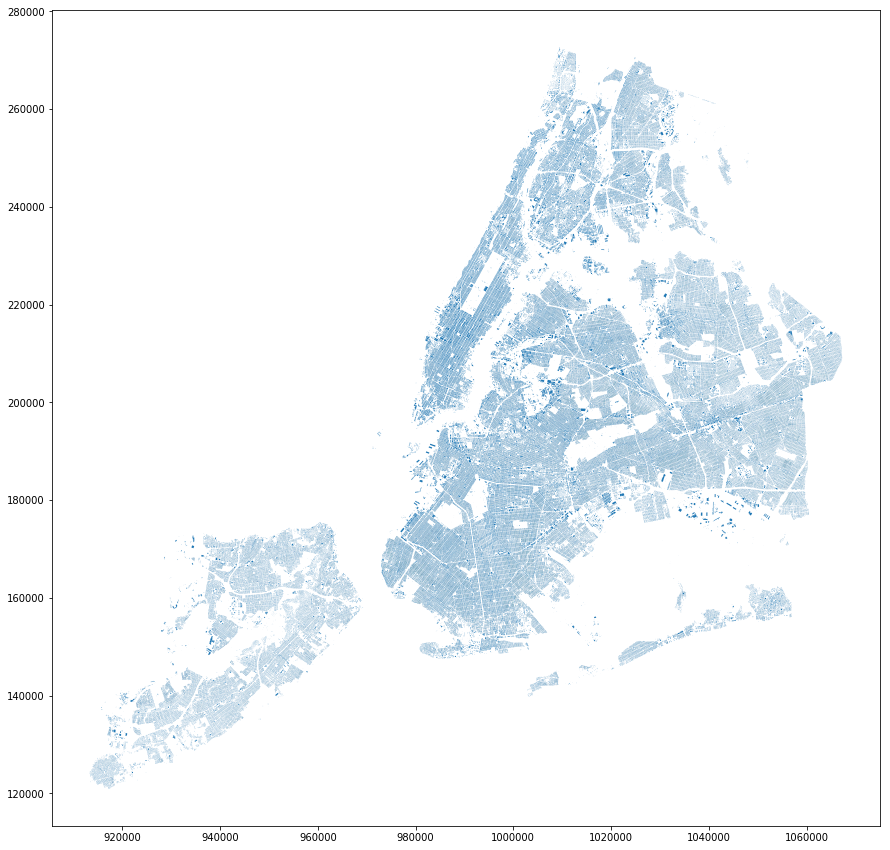

In [224]:
# Check data plots as building footprints
# Plot geometry
FloodFootprints.geometry.plot(figsize=(20,15))

In [225]:
FloodFootprints.head()

,feat_code,doitt_id,cnstrct_yr,date_lstmo,time_lstmo,lststatype,shape_len,bin,groundelev,heightroof,...,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,VEL_UNIT,AR_REVERT,BFE_REVERT,DEP_REVERT,SOURCE_CIT
92453,2100.0,1027609.0,1942.0,2014-07-18,00:00:00.000,Constructed,140.613918,2095149,11.0,28.240000,...,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4
990452,5110.0,690460.0,1942.0,2017-08-22,00:00:00.000,Constructed,87.980887,2095150,12.0,13.450000,...,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4
925629,5110.0,802971.0,1958.0,2017-08-22,00:00:00.000,Constructed,93.942063,2067198,11.0,9.140000,...,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4
1043066,5110.0,1213686.0,1939.0,2017-08-17,00:00:00.000,Constructed,154.362244,2122779,8.0,24.090089,...,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4
834332,2100.0,5536.0,1939.0,2014-07-18,00:00:00.000,Constructed,99.898544,2122777,7.0,16.921271,...,13.0,NAVD88,-9999.0,FEET,-9999.0,None,None,-9999.0,-9999.0,STUDY4


In [226]:
# Save original merge for potential later use
FloodFootprintsOG = FloodFootprints

# Check size
FloodFootprints.shape

(1060482, 29)

In [227]:
# Exclude Builings outside Flood Plain
FloodFootprints = FloodFootprints[FloodFootprints.FLD_ZONE <> 'X']

# Check new size
FloodFootprints.shape

(86602, 29)

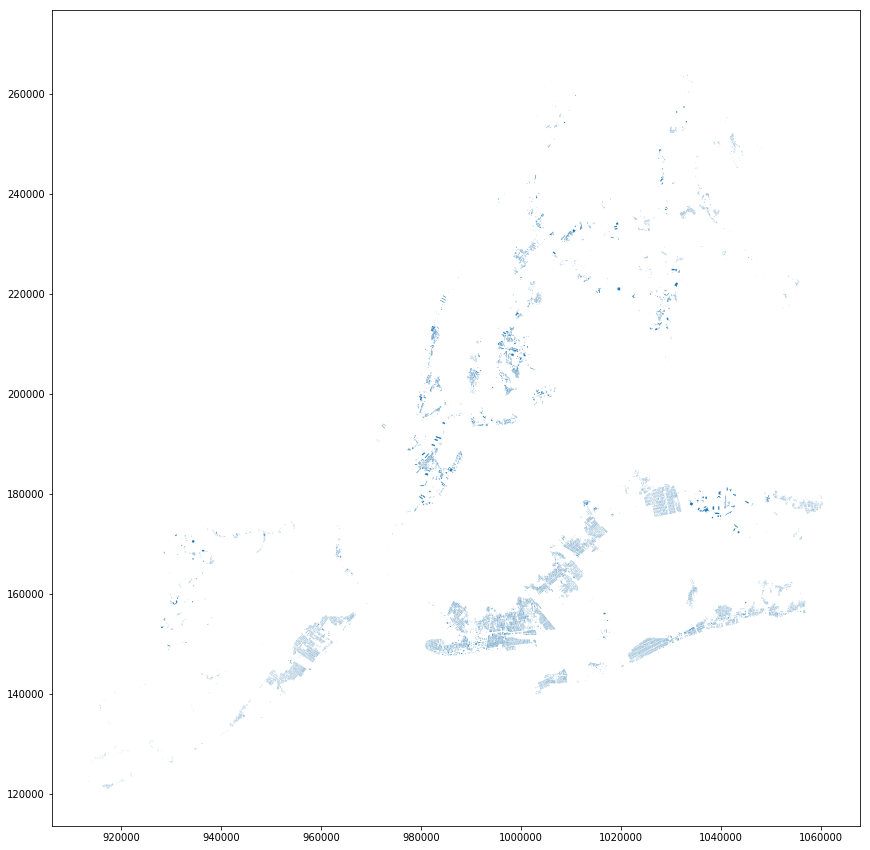

In [228]:
# Check data plots as building footprints
# Plot geometry
FloodFootprints.geometry.plot(figsize=(20,15))

Looking at the data size reduction, it appears we are only looking at buildings in Flood Zones

# Import and Process Pluto Data for each Borough

In [229]:
# Combine Data 
plutoBK = pd.read_csv('BORO_zip_files_csv/BK.csv')
plutoBX = pd.read_csv('BORO_zip_files_csv/BX.csv')
plutoMN = pd.read_csv('BORO_zip_files_csv/MN.csv')
plutoQN = pd.read_csv('BORO_zip_files_csv/QN.csv')
plutoSI = pd.read_csv('BORO_zip_files_csv/SI.csv')

### Because PLUTO data comes separate for each borough, we're concatentating them here to construct a single PLUTO dataset for all of NYC

In [230]:
###############################################################################
# Concatenate PLUTO data from each of 5 borough into single dataset
pluto = pd.concat([plutoBK, plutoBX, plutoMN, plutoQN, plutoSI]).reset_index()
pluto.shape

(858370, 85)

In [231]:
pluto.head(5)

,index,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,...,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,...,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,...,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,...,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,...,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


In [232]:
pluto.columns

Index([u'index', u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'Co

In [233]:
###############################################################################
# Clean data and drop irrelevant columns
pluto.drop(['index','Borough','Block','Lot','SchoolDist','Council','ZipCode',
            'FireComp','PolicePrct','HealthArea','SanitBoro', 'SanitDistrict', 
            'SanitSub', 'Address','Overlay1','Overlay2', 'SPDist1', 'SPDist2', 
            'SPDist3', 'Easements', 'IrrLotCode','HistDist', 'Landmark',
            'BuiltFAR','ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'XCoord', 
            'YCoord', 'ZoneMap', 'ZMCode','Sanborn', 'TaxMap', 'EDesigNum', 
            'APPBBL', 'APPDate', 'Version'], axis=1,inplace=True);

In [234]:
# Drop NAs?

In [235]:
# Convert BBL to string
pluto.BBL = pluto.BBL.astype(int).astype(str)

In [236]:
pluto.head()

,CD,CT2010,CB2010,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,LtdHeight,SplitZone,BldgClass,...,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BBL,CondoNo,Tract2010,PLUTOMapID
0,302,21.0,NaN,M3-1,M1-4/R8A,NaN,NaN,NaN,Y,V1,...,1164645.0,0.0,0.0,0,0,0,3000010001,0,21,1
1,302,21.0,2000.0,M1-4/R8A,M3-1,NaN,NaN,NaN,Y,E9,...,12019950.0,0.0,290250.0,1920,1994,2007,3000010050,0,21,1
2,302,21.0,2000.0,M3-1,NaN,NaN,NaN,NaN,N,RM,...,5864853.0,0.0,0.0,0,0,0,3000017501,3819,21,1
3,302,21.0,3002.0,M3-1,NaN,NaN,NaN,NaN,N,U4,...,0.0,0.0,0.0,0,0,0,3000030001,0,21,1
4,302,21.0,NaN,M3-1,NaN,NaN,NaN,NaN,N,T2,...,21150.0,21150.0,21150.0,0,0,0,3000030005,0,21,4


In [237]:
pluto.columns

Index([u'CD', u'CT2010', u'CB2010', u'ZoneDist1', u'ZoneDist2', u'ZoneDist3',
       u'ZoneDist4', u'LtdHeight', u'SplitZone', u'BldgClass', u'LandUse',
       u'OwnerType', u'OwnerName', u'LotArea', u'BldgArea', u'ComArea',
       u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'LotType', u'BsmtCode',
       u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot', u'YearBuilt',
       u'YearAlter1', u'YearAlter2', u'BBL', u'CondoNo', u'Tract2010',
       u'PLUTOMapID'],
      dtype='object')

# Import and clean DOB permit applications data from DOB open NYC

In [370]:
# Read in DOB Job Application Filings
DOBapps = pd.read_csv('DOBapps.csv', 
                      dtype={'Block': object,'Lot': object,
                             'Bin #':object})
DOBapps.shape

(323325, 82)

In [371]:
DOBapps.head(5)

,Job #,Doc #,Borough,House #,Street Name,Block,Lot,Bin #,Job Type,Job Status,...,Owner's Last Name,Owner's Business Name,Owner's House Number,Owner'sHouse Street Name,City,State,Zip,Owner'sPhone #,Job Description,DOBRunDate
0,121577873,2,MANHATTAN,386,PARK AVENUE SOUTH,00857,00038,1016890,A2,D,...,MIGLIORE,MACKLOWE MANAGEMENT,126,EAST 56TH STREET,NEW YORK,NY,10222,2125545837,GENERAL MECHANICAL & PLUMBING MODIFICATIONS AS...,04/26/2013 12:00:00 AM
1,520129502,1,STATEN ISLAND,107,KNOX PLACE,00342,00001,5161350,A3,A,...,BLUMENBERG,NA,107,KNOX PLACE,STATEN ISLAND,NY,10314,3477398892,BUILDERS PAVEMENT PLAN 143 LF. ...,04/26/2013 12:00:00 AM
2,121601560,1,MANHATTAN,63,WEST 131 STREET,01729,00009,1053831,A2,Q,...,MARKOWITZ,635 RIVERSIDE DRIVE NY LLC,619,WEST 54TH STREET,NEW YORK,NY,10016,2127652555,GENERAL CONSTRUCTION TO INCLUDE NEW PARTITIONS...,04/26/2013 12:00:00 AM
3,121601203,1,MANHATTAN,48,WEST 25TH STREET,00826,00069,1015610,A2,D,...,CASALE,48 W 25 ST LLC C/O BERNSTEIN,150,WEST 30TH STREET,NEW YORK,NY,10001,2125941414,STRUCTURAL CHANGES ON THE 5TH FLOOR (MOONDOG E...,04/26/2013 12:00:00 AM
4,121601338,1,MANHATTAN,45,WEST 29 STREET,00831,00007,1015754,A3,D,...,LEE,HYUNG-HYANG REALTY CORP,614,8 AVENUE,NEW YORK,NY,10001,2019881222,FILING HEREWITH FACADE REPAIR PLANS. WORK SCOP...,04/26/2013 12:00:00 AM


In [372]:
DOBapps.columns

Index([u'Job #', u'Doc #', u'Borough', u'House #', u'Street Name', u'Block',
       u'Lot', u'Bin #', u'Job Type', u'Job Status', u'Job Status Descrp',
       u'Latest Action Date', u'Building Type', u'Community - Board',
       u'Cluster', u'Landmarked', u'Adult Estab', u'Loft Board', u'City Owned',
       u'Little e', u'PC Filed', u'eFiling Filed', u'Plumbing', u'Mechanical',
       u'Boiler', u'Fuel Burning', u'Fuel Storage', u'Standpipe', u'Sprinkler',
       u'Fire Alarm', u'Equipment', u'Fire Suppression', u'Curb Cut', u'Other',
       u'Other Description', u'Applicant's First Name',
       u'Applicant's Last Name', u'Applicant Professional Title',
       u'Applicant License #', u'Professional Cert', u'Pre- Filing Date',
       u'Paid', u'Fully Paid', u'Assigned', u'Approved', u'Fully Permitted',
       u'Initial Cost', u'Total Est. Fee', u'Fee Status',
       u'Existing Zoning Sqft', u'Proposed Zoning Sqft', u'Horizontal Enlrgmt',
       u'Vertical Enlrgmt', u'Enlargement SQ Foo

In [373]:
###############################################################################
# Drop irrelevant columns
DOBapps.drop(['Job #', 'Doc #','Street Name', 'House #',
              'Job Status Descrp','Latest Action Date', 'Community - Board',
              'Cluster', 'Landmarked', 'Adult Estab', 'Loft Board', 
              'Little e', 'PC Filed', 'eFiling Filed', 'Plumbing', 
              'Mechanical','Boiler', 'Fuel Burning', 'Fuel Storage', 
              'Standpipe', 'Sprinkler','Fire Alarm', 'Equipment', 
              'Fire Suppression', 'Curb Cut', 'Other', 
              "Applicant's First Name","Applicant's Last Name", 
              'Applicant Professional Title', 'Professional Cert', 
              'Pre- Filing Date','Paid', 'Fully Paid', 
              'Assigned', 'Approved', 'Fully Permitted','Initial Cost', 
              'Total Est. Fee', 'Fee Status','Existing Zoning Sqft', 
              'Proposed Zoning Sqft', 'Horizontal Enlrgmt','Vertical Enlrgmt', 
              'Enlargement SQ Footage', 'Street Frontage',
              'Site Fill', 'Zoning Dist1', 
              'Zoning Dist2','Zoning Dist3', 'Special District 1', 
              'Special District 2','Owner Type', 'Non-Profit', 
              "Owner's First Name","Owner's Last Name", "Owner's Business Name", 
              "Owner's House Number","Owner'sHouse Street Name", 'City ', 
              'State','Zip',"Owner'sPhone #"],
             axis=1, inplace=True);

In [374]:
# Here we're mapping a digit to each borough name to replicate BBL format
DOBapps['num_boro'] = DOBapps['Borough'].map({'BRONX':'2','BROOKLYN':"3",
                                              'MANHATTAN':'1','STATEN ISLAND':'5',
                                              'QUEENS':'4'})
DOBapps.tail(2)

,Borough,Block,Lot,Bin #,Job Type,Job Status,Building Type,City Owned,Other Description,Applicant License #,...,Proposed No. of Stories,Existing Height,Proposed Height,Existing Dwelling Units,Proposed Dwelling Units,Existing Occupancy,Proposed Occupancy,Job Description,DOBRunDate,num_boro
323323,QUEENS,07314,00033,4156906,A2,R,OTHER,NaN,GEN. CONSTR.,36490,...,2.0,28.0,28.0,NaN,NaN,PUB,PUB,"INSTALLATION OF PARTITION FOR NEW BOILER, INCL...",11/09/2017 12:00:00 AM,4
323324,BROOKLYN,00879,00003,3017069,A2,D,OTHER,NaN,NaN,17489,...,2.0,20.0,20.0,1,1,COM,COM,INSTALLATION OF AUTOMATIC FIRE SUPPRESSION SYS...,11/09/2017 12:00:00 AM,3


In [375]:
# Create BBL column by combining Borough, Block and Lot Numbers
DOBapps["BBL"] = DOBapps['num_boro']+DOBapps["Block"]+DOBapps["Lot"].str[1:]
DOBapps.drop(['Block','num_boro','Lot','Borough'],axis=1,inplace=True)
DOBapps.head(5)

,Bin #,Job Type,Job Status,Building Type,City Owned,Other Description,Applicant License #,ExistingNo. of Stories,Proposed No. of Stories,Existing Height,Proposed Height,Existing Dwelling Units,Proposed Dwelling Units,Existing Occupancy,Proposed Occupancy,Job Description,DOBRunDate,BBL
0,1016890,A2,D,OTHER,NaN,,0058375,0.0,0.0,0.0,0.0,,,,,GENERAL MECHANICAL & PLUMBING MODIFICATIONS AS...,04/26/2013 12:00:00 AM,1008570038
1,5161350,A3,A,1-2-3 FAMILY,NaN,BPP,0025259,0.0,0.0,0.0,0.0,,,,,BUILDERS PAVEMENT PLAN 143 LF. ...,04/26/2013 12:00:00 AM,5003420001
2,1053831,A2,Q,OTHER,NaN,GEN. CONSTR.,0084178,5.0,5.0,54.0,54.0,20,20,RES,RES,GENERAL CONSTRUCTION TO INCLUDE NEW PARTITIONS...,04/26/2013 12:00:00 AM,1017290009
3,1015610,A2,D,OTHER,NaN,STRUCTURAL,0078226,12.0,12.0,120.0,120.0,,,E,E,STRUCTURAL CHANGES ON THE 5TH FLOOR (MOONDOG E...,04/26/2013 12:00:00 AM,1008260069
4,1015754,A3,D,OTHER,NaN,GEN. CONSTR.,0086781,6.0,6.0,64.0,64.0,,,COM,COM,FILING HEREWITH FACADE REPAIR PLANS. WORK SCOP...,04/26/2013 12:00:00 AM,1008310007


In [348]:
# Filter Data set to get permits that affect elevation, Build it Back, etc.
DOBapps.dropna(subset=["Job Description"],inplace=True)
DOBapps['Job Description'] = DOBapps['Job Description'].str.lower()
DOBapps['Job Description'][DOBapps["Job Description"].str.contains('flood|bib|bfe')].count() 

# Other possible ones: elevat,floor,lift

2206

In [349]:
# Filter DOB by jobs related  to Flooding BIB etc.
DOBapps = DOBapps[DOBapps["Job Description"].str.contains('flood|bib|bfe')]

### We have three datasets to merge now (footprints and flood zone combination, PLUTO, and permits); we want to merge them.

Building Footprints and Flood Zone Geometry - FloodFootprints

PLUTO - pluto

DOB Construction Permits - DOBapps

We need to determine best way to merge data, potentially merging DOB with footprints using BIN and Pluto with that by BBL? Maybe a better way?

In [386]:
# Merging DOB Construction Permits with Footprints
BF_merge2 = pd.merge(FloodFootprints, DOBapps, left_on='bin', right_on='Bin #', how='left')

In [387]:
BF_merge2.head()

,feat_code,doitt_id,cnstrct_yr,date_lstmo,time_lstmo,lststatype,shape_len,bin,groundelev,heightroof,...,Proposed No. of Stories,Existing Height,Proposed Height,Existing Dwelling Units,Proposed Dwelling Units,Existing Occupancy,Proposed Occupancy,Job Description,DOBRunDate,BBL
0,2100.0,1027609.0,1942.0,2014-07-18,00:00:00.000,Constructed,140.613918,2095149,11.0,28.240000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5110.0,690460.0,1942.0,2017-08-22,00:00:00.000,Constructed,87.980887,2095150,12.0,13.450000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5110.0,802971.0,1958.0,2017-08-22,00:00:00.000,Constructed,93.942063,2067198,11.0,9.140000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5110.0,1213686.0,1939.0,2017-08-17,00:00:00.000,Constructed,154.362244,2122779,8.0,24.090089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2100.0,5536.0,1939.0,2014-07-18,00:00:00.000,Constructed,99.898544,2122777,7.0,16.921271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [388]:
FloodFootprints.shape

(86602, 29)

In [389]:
BF_merge2.shape

(99435, 47)

In [264]:
# Merge Pluto Data to Building Footprints

In [406]:
three_way = pd.merge(BF_merge2, pluto, left_on='bbl', right_on='BBL')

In [407]:
three_way.head()

,feat_code,doitt_id,cnstrct_yr,date_lstmo,time_lstmo,lststatype,shape_len,bin,groundelev,heightroof,...,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,BBL_y,CondoNo,Tract2010,PLUTOMapID
0,2100.0,1027609.0,1942.0,2014-07-18,00:00:00.000,Constructed,140.613918,2095149,11.0,28.240000,...,568800.0,0.0,0.0,1942,0,0,2049740070,0,456,1
1,5110.0,690460.0,1942.0,2017-08-22,00:00:00.000,Constructed,87.980887,2095150,12.0,13.450000,...,568800.0,0.0,0.0,1942,0,0,2049740070,0,456,1
2,2100.0,764314.0,1942.0,2014-07-18,00:00:00.000,Constructed,121.229794,2095146,8.0,14.940000,...,568800.0,0.0,0.0,1942,0,0,2049740070,0,456,1
3,5110.0,802971.0,1958.0,2017-08-22,00:00:00.000,Constructed,93.942063,2067198,11.0,9.140000,...,167850.0,0.0,0.0,1958,0,0,2049740088,0,456,1
4,2100.0,658068.0,1958.0,2014-07-18,00:00:00.000,Constructed,156.269672,2095148,10.0,19.094666,...,167850.0,0.0,0.0,1958,0,0,2049740088,0,456,1


In [408]:
three_way.shape

(99073, 94)

In [409]:
three_way.to_csv('Threeway.csv')